#Joint Entity recognition and relation Extraction


In this Notebook, we will discus the detail about Named Entity Recognition (NER) and Relation Extraction using a joint neural model, which performs entity recognition and relation extraction simultaneously, without the need of any manually extracted features or the use of anyexternal tool. 

For this specific task I have implemented the paper below:

* [Giannis Bekoulis, Johannes Deleu, Thomas Demeester, Chris Develder. Joint entity recognition and relation extraction as a multi-head selection problem. Expert Systems with Applications, Volume 114, Pages 34-45, 2018](https://arxiv.org/pdf/1804.07847.pdf)




1.**Introduction**

In Natural Language Processing (NLP) an Entity Recognition and Relation Extraction is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. 

The goal of the entity recognition and relation extraction is to discover relational struc-tures of entity mentions from unstructured texts. It is a central problem in information extraction since it is critical for tasks such as knowledge base population and questionanswering.

#Change Runtime to GPU

On the main menu, click on Runtime and select Change  runtime type. Set "GPU" as the hardware accelerator.



#Clone Repository:

First Step is to clone my Github Repository. Below code is command to clone repository:

In [ ]:
!git clone https://github.com/kedir/Joint-Entity-recognition-and-relation-Extraction-using-joint-neural-model.git

#Mounting Google Drive locally

mount your Google Drive on your runtime using an authorization code. Go to the URL, copy and Enter your authorization code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
mv /content/multihead_joint_entity_relation_extraction /content/drive/My\ Drive

# Installing packages
contains all the pacakages that required for trainig and inference. By using below command install all the pacakages.


In [6]:
!pip install Numpy==1.17.1 Gensim==3.4.0 Tensorflow==1.13.1 PrettyTable==0.7.2 pandas

     |████████████████████████████████| 20.3MB 1.4MB/s 
     |████████████████████████████████| 22.2MB 96kB/s 
     |████████████████████████████████| 92.6MB 32kB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 368kB 52.6MB/s 
     |████████████████████████████████| 3.2MB 47.9MB/s 
  Created wheel for Gensim: filename=gensim-3.4.0-cp37-cp37m-linux_x86_64.whl size=23316480 sha256=68f173369c43ee0a21e5829c98d0e7569b408c53e99155ee5c210646f430f7f6
  Stored in directory: /root/.cache/pip/wheels/2a/5f/2d/04fe5cffea90fbba14c8eab40f519096c8558cceaaa6777048
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp37-none-any.whl size=13700 sha256=58527b59a4ca0215ce1a69d9881dd4181fea8bb93d2e18d2ed8952b7fbd6e3b6
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built Gensim PrettyTable
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which

In [1]:
 #Check the version 
 import pandas
pandas.__version__

'1.1.5'

#2. **Understanding the data:**
I have used the dataset from **[CoNLL04](https://cogcomp.seas.upenn.edu/Data/ER/):** one of the most basic dataset, concentrating on four types of named entities related to (Persons, Location, Organization, and others) and and five relation types (Kill, Live in, Located in, OrgBased in and Workfor). CONLL 2004 follow BIO schema which contain four columns separated by a single space.BIO (Beginning, Inside, Outside) schema is a common tagging format for tagging sentence tokens for NER. Here B-prefix indicates that the tag is at the beginning of every chunk. Same I-prefix for Inside of Chunk and O-prefix for no entity inside chunk. 

The following example indicates the accepted dataset format:

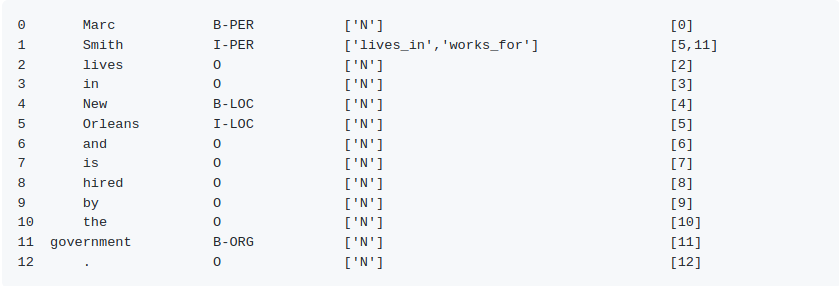


In [ ]:
# reading the training, develpoment and test dataset 
import pandas as pd
import numpy as np
import csv
head_id_col_vector = ['token_id', 'token', "BIO", "relation", 'head']
train = pd.read_csv("/content/drive/MyDrive/multihead_joint_entity_relation_extraction_model/data/CoNLL04/train.txt", names=head_id_col_vector, encoding="utf-8",engine='python', sep="\t", quoting=csv.QUOTE_NONE)
dev = pd.read_csv("/content/drive/MyDrive/multihead_joint_entity_relation_extraction_model/data/CoNLL04/dev.txt", names=head_id_col_vector, encoding="utf-8",engine='python', sep="\t", quoting=csv.QUOTE_NONE)
test = pd.read_csv("/content/drive/MyDrive/multihead_joint_entity_relation_extraction_model/data/CoNLL04/test.txt", names=head_id_col_vector, encoding="utf-8",engine='python', sep="\t", quoting=csv.QUOTE_NONE)


In [ ]:
data = pd.concat([train, dev, test], ignore_index=True)

In [ ]:
data.head(10)

,token_id,token,BIO,relation,head
0,#doc 1024,None,None,None,None
1,0,Very,O,['N'],[0]
2,1,strong,O,['N'],[1]
3,2,south,O,['N'],[2]
4,3,winds,O,['N'],[3]
5,4,accompanied,O,['N'],[4]
6,5,the,O,['N'],[5]
7,6,storm,O,['N'],[6]
8,7,system,O,['N'],[7]
9,8,",",O,['N'],[8]


In [ ]:
train.describe()

,token_id,token,BIO,relation,head
count,27714,26804,26804,26804,26804
unique,1023,6388,9,23,219
top,1,",",O,['N'],[0]
freq,910,1822,20503,25686,904


In [ ]:
dev.describe()

,token_id,token,BIO,relation,head
count,7218,6975,6975,6975,6975
unique,357,2743,9,13,150
top,1,",",O,['N'],[0]
freq,243,444,5355,6666,248


In [ ]:
test.describe()

,token_id,token,BIO,relation,head
count,8696,8408,8408,8408,8408
unique,407,2989,9,15,156
top,1,",",O,['N'],[1]
freq,288,541,6384,8040,288


In [ ]:
data.describe()

,token_id,token,BIO,relation,head
count,43628,42187,42187,42187,42187
unique,1560,8596,9,25,286
top,0,",",O,['N'],[0]
freq,1441,2807,32242,40392,1439


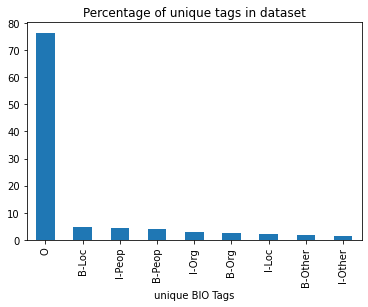

In [ ]:
import matplotlib.pyplot as plt

(data['BIO'].value_counts(normalize=True)*100).plot.bar()
plt.xlabel("unique BIO Tags")
plt.title('Percentage of unique tags in dataset')
plt.show()


Observations :

* There are total 1441( 910 training instances, 243 for validation and 288 for testing) sentences in the dataset 

* Number unique words in the dataset are 8596.
    
* Total 9 lables (BIO Tags).





#3. Train, Evaluate and test the model
bold textThe model use the following python file:

*  train_es.py 
Train the model on the train set and evaluate on the evaluation and test sets until maximum epochs limit or (2) early stopping break'

*   eval.py 
Set of classes and methods for computing and printing the results using the strict, boundaries and relaxed evaluation methods.
For more info about how to use them see tf_utils.py







In [ ]:
!cd /content/drive/My\ Drive/multihead_joint_entity_relation_extraction_model && chmod +x run.sh

In [ ]:
!cd /content/drive/My\ Drive/multihead_joint_entity_relation_extraction_model && ./run.sh

Streaming output truncated to the last 5000 lines.
| Micro REL chunk | 0  | 5064 | 1273 | 0  | 0  | 0  |
+-----------------+----+------+------+----+----+----+
Elapsed train time in sec:35.52627468109131

-------Evaluate on dev-------
+-----------------+----+----+-----+--------------------+-----------------------+----------------------+
|      Class      | TP | FP |  FN |         Pr         |           Re          |          F1          |
+-----------------+----+----+-----+--------------------+-----------------------+----------------------+
|       Loc       | 0  | 0  | 337 |         0          |           0           |          0           |
|       Org       | 6  | 5  | 184 | 0.5454545454545454 |  0.031578947368421054 | 0.05970149253731343  |
|      Other      | 0  | 0  | 125 |         0          |           0           |          0           |
|       Peop      | 0  | 0  | 225 |         0          |           0           |          0           |
|        -        | -  | -  |  -  |   

# Prepare the test data to CONLL dataset format 
I just took this sentence from test dataset and convert into CoNLL04 dataset format 

In [ ]:
test_sentence=[
           {
               "id": 5124,
               'text':'In 1969 , James Earl Ray pleaded guilty in Memphils, Tenn. , to the assassinations of civil rights leader Martin Luther King Jr.'
           }
]

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/multihead_joint_entity_relation_extraction_model")
import time
import utils 
from build_data import build_data
import parsers
import os
import numpy as np
import pandas as pd
import csv
os.chdir("/content/drive/My Drive/multihead_joint_entity_relation_extraction_model/")
testconfig = build_data("/content/drive/My Drive/multihead_joint_entity_relation_extraction_model/configs/CoNLL04/bio_config")
RELset = testconfig.dataset_set_relations
nerSegmentationTags=testconfig.dataset_set_bio_tags
hiden_size = testconfig.hidden_size_n1
dataset_set_characters = testconfig.dataset_set_characters
test_data = utils.HeadData(testconfig.test_id_docs, np.arange(len(testconfig.test_id_docs)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
# The function accepts test_sentence and convert into an input format(CoNLL04 datset format)
def parseinput(sentences):
    head_id_col_vector = ['token_id', 'token', "BIO", "relation", 'head']
    data = pd.DataFrame([],columns=head_id_col_vector)
    for s in sentences:
        sent = s['text'].strip().replace("\t","")
        sent_tokens = sent.split(" ")
        sent_id = s["id"]
        data.loc[len(data)] = ["#doc "+str(sent_id), None, None, None,None]
        i = 0
        for t in sent_tokens:
            for c in t:
                if not c in dataset_set_characters:
                    dataset_set_characters.append(c)
            data.loc[len(data)] = [i, t, "O", "['N']","[{}]".format(i)] 
            i+=1
    return data

In [ ]:
# convert test_sentence into input format and save to csv as 'sample_sent.csv'
input_sent = parseinput(test_sentence)
input_sent.to_csv('/content/drive/MyDrive/multihead_joint_entity_relation_extraction_model/test_sentence',sep="\t",index=False, header=False)
input_sent.head(10)

,token_id,token,BIO,relation,head
0,#doc 5124,None,None,None,None
1,0,In,O,['N'],[0]
2,1,1969,O,['N'],[1]
3,2,",",O,['N'],[2]
4,3,James,O,['N'],[3]
5,4,Earl,O,['N'],[4]
6,5,Ray,O,['N'],[5]
7,6,pleaded,O,['N'],[6]
8,7,guilty,O,['N'],[7]
9,8,in,O,['N'],[8]


In [ ]:
    test_sentence = parsers.readHeadFile('/content/drive/MyDrive/multihead_joint_entity_relation_extraction_model/test_sentence')
    # preprocess the dataframe
    parsers.preprocess(test_sentence, testconfig.wordindices, dataset_set_characters,
        testconfig.dataset_set_bio_tags, testconfig.dataset_set_ec_tags, testconfig.dataset_set_relations)
    test_data = utils.HeadData(test_sentence, np.arange(len(test_sentence)))

#4. Prediction


*   Apply the model to a test_sentence

In [ ]:
nerSegmentationTags

['B-Loc',
 'B-Org',
 'B-Other',
 'B-Peop',
 'I-Loc',
 'I-Org',
 'I-Other',
 'I-Peop',
 'O']

In [ ]:
RELset 


['Kill', 'Live_In', 'Located_In', 'N', 'OrgBased_In', 'Work_For']

In [ ]:
# The function accept the model output both NER and REL(relation)

#.............. input pred_batchesNER look like......

# pred_batchesNER = [[8 8 8 3 7 7 8 8 8 0 4 8 8 8 8 8 8 8 8 3 7 7 7]]  
# we can convert pred_batchesNER based on nerSegmentationTags and it become
# pred_batchesNER = [['O','O','O','B-Other','I-Peop','I-Peop','O','O','O','B-Loc','I-Loc','O',
# 'O','O','O','O','O','O','B-Other','I-Peop','I-Peop','I-Peop']]

#--------------- Output ........
# NER=[('Peop', 3, 5), ('Peop', 19, 22), ('Loc', 9, 10)]
# NER output tells us starting from token 3 upto 5 there is an entity and its entity type is People. 
# REL=[(5, 'Kill', 22)]
# The REL output indicates that there is a relation between entity 5 and entity 22 which has 'Kill' relation type

def add_test(pred_batchesNER,pred_batchesREL):

        for batch_idx in range(len(pred_batchesREL)):
            predRel = pred_batchesREL[batch_idx]
            predNER = pred_batchesNER[batch_idx]
            ptoken_ids, _, plabel_ids, phead_ids, plabel_names = utils.transformToInitialInput(
                predRel, RELset)
            tagsNER = utils.getSegmentationDict(nerSegmentationTags)
            predRel = getTokenRelations(plabel_names, phead_ids, ptoken_ids)
            lab_pred_chunks = set(get_chunks(predNER, tagsNER))
            return predRel, list(lab_pred_chunks)

def getTokenRelations(label_names, head_ids, token_ids):
        relations = []
        for labelLIdx in range(len(label_names)):
            # print (predLabel)
            labelL = label_names[labelLIdx]
            headL = head_ids[labelLIdx]
            tokenId = token_ids[labelLIdx]
            for labelIdx in range(len(labelL)):

                label = labelL[labelIdx]
                head = headL[labelIdx]
                if label != "N":
                    # print (label)
                    relations.append((tokenId, label, head))
                    # print (tokenId,label,head)
        return relations
      
def get_chunk_type(tok, idx_to_tag):
    # method implemented in https://github.com/guillaumegenthial/sequence_tagging/blob/master/model/data_utils.py
    """
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}
    Returns:
        tuple: "B", "PER"
    """
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

def get_chunks(seq, tags):
    # method implemented in https://github.com/guillaumegenthial/sequence_tagging/blob/master/model/data_utils.py
    """Given a sequence of tags, group entities and their position
    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4
    Returns:
        list of (chunk_type, chunk_start, chunk_end)
    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]
    """

    default = tags['O']
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    chunks = []
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i-1)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                chunk = (chunk_type, chunk_start, i-1)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq)-1)
        chunks.append(chunk)

    return chunks

In [ ]:
def parseresult(ner, rel, doc_id, tokens):
    # ner=[('Peop', 3, 5), ('Peop', 19, 22),('Loc', 9, 10)]
    # rel=[(5, 'Kill', 22)]
    output = {"{}".format(doc_id): []}
    entities_dict = {"entities":[]}
    entities_dict_process = {"entities":[]}
    for e in ner:
        if len(e) > 0:
            entity_type = e[0]
            entity_start = e[1]
            entity_end = e[2]
            entity = " ".join(tokens[entity_start:entity_end+1])
            entities_dict_process["entities"].append({"entity":entity, "type":entity_type, "start":entity_start, "end":entity_end})
            entities_dict["entities"].append({"entity":entity, "entity_type":entity_type})
            print(entity)
    relations_dict = {"relations":[]}
    for r in rel:
        if len(r) > 0:
            rel_type = r[1]
            first_entity_ind = r[0]
            second_entity_ind = r[2]
            for ent in entities_dict_process["entities"]:
                if int(ent["end"]) == int(first_entity_ind):
                    first_entity = ent["entity"]
                elif int(ent["end"]) == int(second_entity_ind):
                    second_entity = ent["entity"]
            relations_dict["relations"].append({"relation_type":rel_type, "entities":[first_entity, second_entity]})
            print([first_entity, second_entity])
    output[doc_id].append(entities_dict)
    output[doc_id].append(relations_dict)

    return output

In [ ]:
# load the trained and saved pb_model as a graph and predict  
import tensorflow as tf
import pprint
export_path = '/content/drive/My Drive/multihead_joint_entity_relation_extraction_model/logs/saved_model/v1/'

# We start a session using a temporary fresh Graph
with tf.Session(graph=tf.Graph()) as sess:

    tf.saved_model.loader.load(sess, ['serve'], export_path)
    graph = tf.get_default_graph()
    m = {}
    m['isTrain'] = graph.get_tensor_by_name("Placeholder_1:0")
    m['embeddingIds'] = graph.get_tensor_by_name("Placeholder_3:0")
    m['charIds'] = graph.get_tensor_by_name("Placeholder:0")
    m['tokensLens'] = graph.get_tensor_by_name("Placeholder_2:0")
    m['entity_tags_ids'] = graph.get_tensor_by_name("Placeholder_5:0")
    m['scoringMatrixGold'] = graph.get_tensor_by_name("Placeholder_6:0")
    m['seqlen'] = graph.get_tensor_by_name("Placeholder_10:0")
    m['doc_ids'] = graph.get_tensor_by_name("Placeholder_11:0")
    m['tokenIds'] = graph.get_tensor_by_name("Placeholder_4:0")
    m['dropout_embedding']=graph.get_tensor_by_name("dropout_embedding_keep:0")
    m['dropout_lstm']=graph.get_tensor_by_name("dropout_lstm_keep:0")
    m['dropout_lstm_output']=graph.get_tensor_by_name("dropout_lstm_output_keep:0")
    m['dropout_fcl_ner']=graph.get_tensor_by_name("dropout_fcl_ner_keep:0")
    m['dropout_fcl_rel'] = graph.get_tensor_by_name("dropout_fcl_rel_keep:0")
    m['tokens'] = graph.get_tensor_by_name("Placeholder_7:0")
    m['BIO'] = graph.get_tensor_by_name("Placeholder_8:0")
    m['entity_tags'] = graph.get_tensor_by_name("Placeholder_9:0")
    print( m['doc_ids'])
    op_rel = graph.get_tensor_by_name("loss_computation/Round:0")
    op_ner = graph.get_tensor_by_name("loss_computation/cond_2/Merge:0")

    output_result=[]
    for x_dev in utils.generator(test_data, m, testconfig, train=False):
      pred_rel, pred_ner = sess.run([op_rel, op_ner],feed_dict=x_dev)
      rel, ner = add_test(pred_ner, pred_rel)
      for i in x_dev.keys():
        if "Placeholder_11" in str(i):
          doc_id = x_dev[i][0]
        elif "Placeholder_7" in str(i):
          tokens = x_dev[i][0]
      output_result.append(parseresult(ner, rel,doc_id, tokens))
    pprint.pprint(output_result)      
        

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/multihead_joint_entity_relation_extraction_model/logs/saved_model/v1/variables/variables
Tensor("Placeholder_11:0", shape=(?,), dtype=string)
James Earl Ray
Martin Luther King Jr.
Memphils, Tenn.
['James Earl Ray', 'Martin Luther King Jr.']
[{'#doc 5124': [{'entities': [{'entity': 'James Earl Ray',
                               'entity_type': 'Peop'},
                              {'entity': 'Martin Luther King Jr.',
                               'entity_type': 'Peop'},
                              {'entity': 'Memphils, Tenn.',
                               'entity_type': 'Loc'}]},
                {'relations': [{'entities': ['James Earl Ray',
                                             'Martin Luther King Jr.'],
                                'relation_type': 'Kill'}]}]}]


#Predction Result

The model returns a JSON result which identifies:

1.    James Earl Ray, Martin Luther King Jr,  'Memphils, Tenn.' as an entity and  'Peop', 'Peop', 'Loc' as an entity type respectively.
2.   James Earl Ray and Martin Luther King Jr have a relationship and there relation type is 'Kill'.